# Imports and configs

In [1]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = ['MS Gothic', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import optuna
import joblib
import glob
import gc
import time

warnings.filterwarnings("ignore")

In [2]:
class CFG:
    train_path = "input/train.csv"
    train_demographic_path = "input/train_demographics.csv"
    test_path = "input/test.csv"
    test_demographic_path = "input/test_demographics.csv"

    target = "gesture"
    features_train_only = ['sequence_type', 'orientation']

    n_folds = 5
    seed = 42

    run_optuna = True
    n_optuna_trials = 100 

# Data loading

In [3]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2

    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        # 数値型の列のみ処理
        if np.issubdtype(col_type, np.number):
            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [4]:
train = pd.read_csv(CFG.train_path).reset_index(drop=True)
train_d = pd.read_csv(CFG.train_demographic_path).reset_index(drop=True)
test = pd.read_csv(CFG.test_path).reset_index(drop=True)
test_d = pd.read_csv(CFG.test_demographic_path).reset_index(drop=True)

In [5]:
train_reduced = train.copy()
train_reduced = reduce_mem_usage(train_reduced, "train")
test_reduced = test.copy()
test_reduced = reduce_mem_usage(test_reduced, "test")

# X = train_reduced.drop(columns=CFG.target, axis=1)
# y = train_reduced[CFG.target]
# X_test = test_reduced

# X.head()

Reducing memory usage for: train
--- Memory usage before: 1495.79 MB
--- Memory usage after: 400.27 MB
--- Decreased memory usage by 73.2%

Reducing memory usage for: test
--- Memory usage before: 0.27 MB
--- Memory usage after: 0.07 MB
--- Decreased memory usage by 74.3%



# EDA

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574945 entries, 0 to 574944
Columns: 341 entries, row_id to tof_5_v63
dtypes: float64(332), int64(1), object(8)
memory usage: 1.5+ GB


## Target variable

In [7]:
# Gesture別のsequence_typeを取得
gesture_sequence = train_reduced.groupby(['gesture', 'sequence_type']).size().unstack(fill_value=0)

# Target（BFRB）gestures
target_gestures = gesture_sequence[gesture_sequence['Target'] > 0].index.tolist()
print(f"\n📌 Target（BFRB）Gestures: {len(target_gestures)} categories")
for gesture in target_gestures:
    print(f"  • {gesture}")

# Non-Target（非BFRB）gestures  
non_target_gestures = gesture_sequence[gesture_sequence['Non-Target'] > 0].index.tolist()
print(f"\n📌 Non-Target（Non-BFRB）Gestures: {len(non_target_gestures)} categories")
for gesture in non_target_gestures:
    print(f"  • {gesture}")


📌 Target（BFRB）Gestures: 8 categories
  • Above ear - pull hair
  • Cheek - pinch skin
  • Eyebrow - pull hair
  • Eyelash - pull hair
  • Forehead - pull hairline
  • Forehead - scratch
  • Neck - pinch skin
  • Neck - scratch

📌 Non-Target（Non-BFRB）Gestures: 10 categories
  • Drink from bottle/cup
  • Feel around in tray and pull out an object
  • Glasses on/off
  • Pinch knee/leg skin
  • Pull air toward your face
  • Scratch knee/leg skin
  • Text on phone
  • Wave hello
  • Write name in air
  • Write name on leg


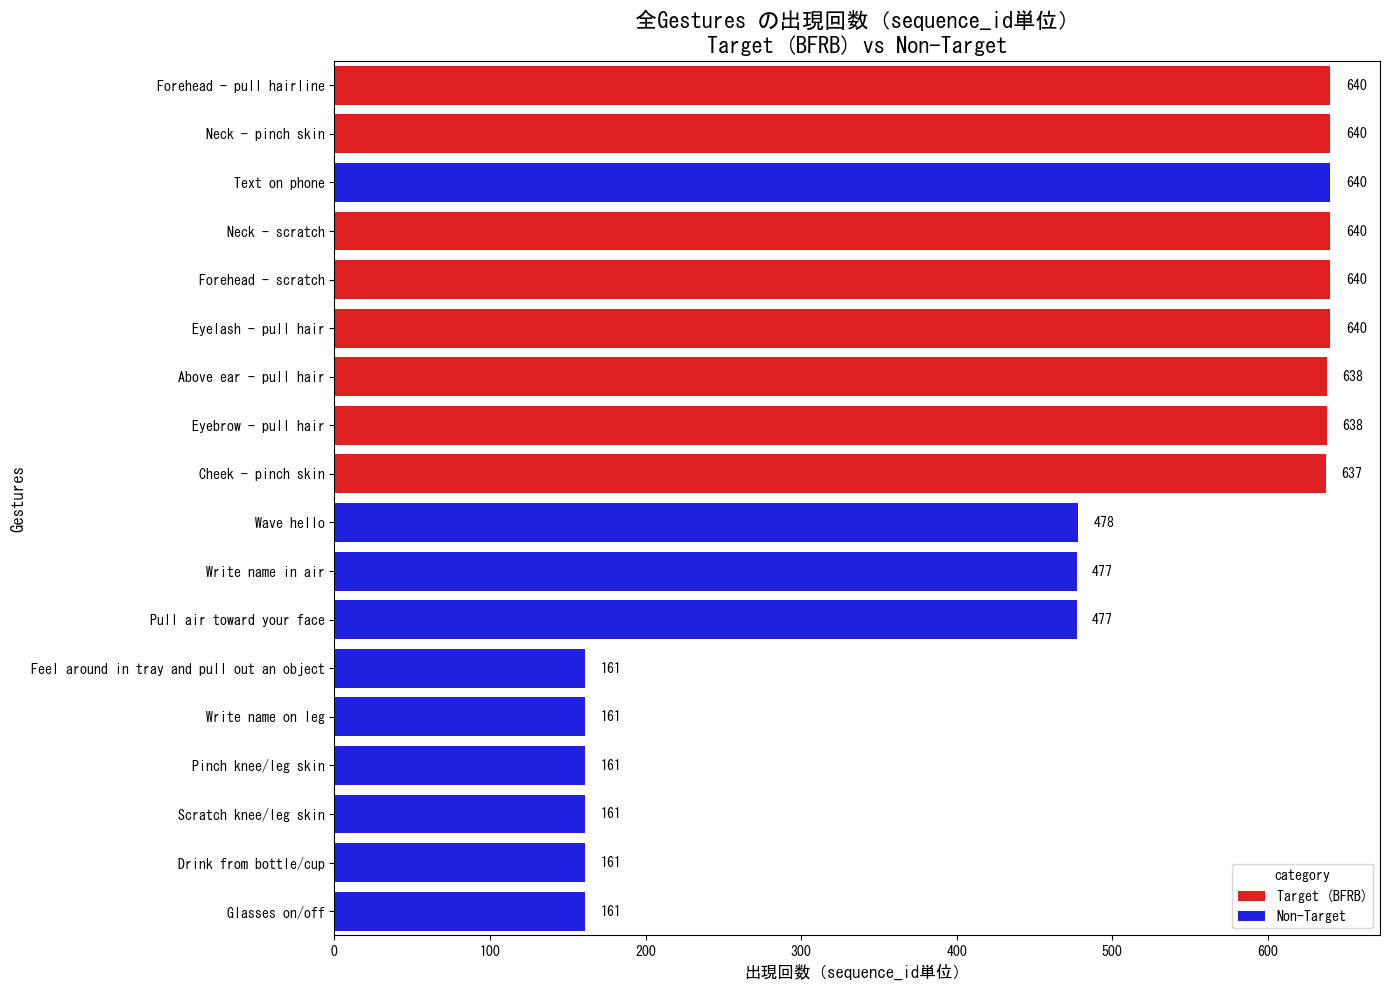

In [8]:
all_gestures = target_gestures + non_target_gestures
unique_gesture_per_sequence = train_reduced.groupby('sequence_id')['gesture'].first().reset_index()
all_gesture_counts = unique_gesture_per_sequence['gesture'].value_counts()

gesture_categories = []
for gesture in all_gesture_counts.index:
    if gesture in target_gestures:
        gesture_categories.append('Target (BFRB)')
    else:
        gesture_categories.append('Non-Target')

gesture_df = pd.DataFrame({
    'gesture': all_gesture_counts.index,
    'count': all_gesture_counts.values,
    'category': gesture_categories
})

# 棒グラフ作成
plt.figure(figsize=(14, 10))
sns.barplot(data=gesture_df, x='count', y='gesture', hue='category', 
            palette={'Target (BFRB)': 'red', 'Non-Target': 'blue'}, orient='h')

plt.title('全Gestures の出現回数（sequence_id単位）\nTarget (BFRB) vs Non-Target', 
          fontsize=16, fontweight='bold')
plt.xlabel('出現回数（sequence_id単位）', fontsize=12)
plt.ylabel('Gestures', fontsize=12)

# 各バーに数値を表示
for i, v in enumerate(gesture_df['count'].values):
    plt.text(v + 10, i, str(v), va='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [9]:
print(f"\n📊 全Gestures の統計情報:")
print(f"  Total unique sequences: {train['sequence_id'].unique().shape[0]:,}")

print(f"\nカテゴリ別統計:")
target_total = gesture_df[gesture_df['category'] == 'Target (BFRB)']['count'].sum()
non_target_total = gesture_df[gesture_df['category'] == 'Non-Target']['count'].sum()
print(f"  Target (BFRB) total sequences: {target_total:,}")
print(f"  Non-Target total sequences: {non_target_total:,}")
print(f"  Target ratio: {target_total/(target_total+non_target_total)*100:.1f}%")


📊 全Gestures の統計情報:
  Total unique sequences: 8,151

カテゴリ別統計:
  Target (BFRB) total sequences: 5,113
  Non-Target total sequences: 3,038
  Target ratio: 62.7%


- 少しBFRBが多いが、ひとまずは気にしない。

## Check for missing values

In [10]:
null_counts = train.isnull().sum()
for col in null_counts[null_counts > 0].index:
    print(f"{col}: {null_counts[col]}")


rot_w: 3692
rot_x: 3692
rot_y: 3692
rot_z: 3692
thm_1: 6987
thm_2: 7638
thm_3: 6472
thm_4: 6224
thm_5: 33286
tof_1_v0: 6224
tof_1_v1: 6224
tof_1_v2: 6224
tof_1_v3: 6224
tof_1_v4: 6224
tof_1_v5: 6224
tof_1_v6: 6224
tof_1_v7: 6224
tof_1_v8: 6224
tof_1_v9: 6224
tof_1_v10: 6224
tof_1_v11: 6224
tof_1_v12: 6224
tof_1_v13: 6224
tof_1_v14: 6224
tof_1_v15: 6224
tof_1_v16: 6224
tof_1_v17: 6224
tof_1_v18: 6224
tof_1_v19: 6224
tof_1_v20: 6224
tof_1_v21: 6224
tof_1_v22: 6224
tof_1_v23: 6224
tof_1_v24: 6224
tof_1_v25: 6224
tof_1_v26: 6224
tof_1_v27: 6224
tof_1_v28: 6224
tof_1_v29: 6224
tof_1_v30: 6224
tof_1_v31: 6224
tof_1_v32: 6224
tof_1_v33: 6224
tof_1_v34: 6224
tof_1_v35: 6224
tof_1_v36: 6224
tof_1_v37: 6224
tof_1_v38: 6224
tof_1_v39: 6224
tof_1_v40: 6224
tof_1_v41: 6224
tof_1_v42: 6224
tof_1_v43: 6224
tof_1_v44: 6224
tof_1_v45: 6224
tof_1_v46: 6224
tof_1_v47: 6224
tof_1_v48: 6224
tof_1_v49: 6224
tof_1_v50: 6224
tof_1_v51: 6224
tof_1_v52: 6224
tof_1_v53: 6224
tof_1_v54: 6224
tof_1_v55: 6224
tof_1

### rot data

In [38]:
for rot_col in ['rot_w', 'rot_x', 'rot_y', 'rot_z']:
    null_sequence_id = train[train[rot_col].isnull()]['sequence_id'].unique()
    partial_null_sequence_id = []

    for seq_id in null_sequence_id:
        seq = train[train['sequence_id'] == seq_id][rot_col]
        null_count = seq.isnull().sum()

        if null_count != len(seq):
            partial_null_sequence_id.append(seq_id)

    print(f"{rot_col} null_sequence_ratio: {len(null_sequence_id)} / {train['sequence_id'].nunique()}")
    print(f"{rot_col} partial_null_sequence_id: {partial_null_sequence_id}")

rot_w null_sequence_ratio: 50 / 8151
rot_w partial_null_sequence_id: []
rot_x null_sequence_ratio: 50 / 8151
rot_x partial_null_sequence_id: []
rot_y null_sequence_ratio: 50 / 8151
rot_y partial_null_sequence_id: []
rot_z null_sequence_ratio: 50 / 8151
rot_z partial_null_sequence_id: []


In [39]:
seq_null_flag = (
    train
    .groupby(['subject', 'sequence_id'])['rot_w']
    .apply(lambda x: x.isnull().any())
    .reset_index()
    .rename(columns={'rot_w': 'is_null_in_seq'})
)

subject_null_percent = (
    seq_null_flag
    .groupby('subject')['is_null_in_seq']
    .mean()
    .mul(100)  # パーセントに変換
    .round(2)  # 小数点2桁に丸める
    .sort_values(ascending=False)
)

print("各subjectごとのsequence_id単位でのrot_w欠損割合（%）:")
print(subject_null_percent.head(5))

各subjectごとのsequence_id単位でのrot_w欠損割合（%）:
subject
SUBJ_058967    23.53
SUBJ_055211    17.65
SUBJ_053217    14.81
SUBJ_001430     0.00
SUBJ_004117     0.00
Name: is_null_in_seq, dtype: float64


- 欠損は少ないのでまずは除外してみる。
- 必要であればaccや姿勢データからの補間を検討する。

### thm, tof data

In [24]:
for thm_col in [f'thm_{i}' for i in range(1, 6)]:
    null_sequence_id = train[train[thm_col].isnull()]['sequence_id'].unique()
    partial_null_sequence_id = []

    for seq_id in null_sequence_id:
        seq = train[train['sequence_id'] == seq_id][thm_col]
        null_count = seq.isnull().sum()

        if null_count != len(seq):
            partial_null_sequence_id.append(seq_id)

    print(f"{thm_col} null_sequence_ratio: {len(null_sequence_id)} / {train['sequence_id'].nunique()}")
    print(f"{thm_col} partial_null_sequence_id: {partial_null_sequence_id}")

thm_1 null_sequence_ratio: 104 / 8151
thm_1 partial_null_sequence_id: []
thm_2 null_sequence_ratio: 117 / 8151
thm_2 partial_null_sequence_id: ['SEQ_044963']
thm_3 null_sequence_ratio: 100 / 8151
thm_3 partial_null_sequence_id: []
thm_4 null_sequence_ratio: 96 / 8151
thm_4 partial_null_sequence_id: []
thm_5 null_sequence_ratio: 483 / 8151
thm_5 partial_null_sequence_id: ['SEQ_062104']


In [25]:
for tof_col in [f'tof_{i}_v0' for i in range(1, 6)]:
    null_sequence_id = train[train[tof_col].isnull()]['sequence_id'].unique()
    partial_null_sequence_id = []

    for seq_id in null_sequence_id:
        seq = train[train['sequence_id'] == seq_id][tof_col]
        null_count = seq.isnull().sum()

        if null_count != len(seq):
            partial_null_sequence_id.append(seq_id)

    print(f"{tof_col} null_sequence_ratio: {len(null_sequence_id)} / {train['sequence_id'].nunique()}")
    print(f"{tof_col} partial_null_sequence_id: {partial_null_sequence_id}")

tof_1_v0 null_sequence_ratio: 96 / 8151
tof_1_v0 partial_null_sequence_id: []
tof_2_v0 null_sequence_ratio: 96 / 8151
tof_2_v0 partial_null_sequence_id: []
tof_3_v0 null_sequence_ratio: 96 / 8151
tof_3_v0 partial_null_sequence_id: []
tof_4_v0 null_sequence_ratio: 96 / 8151
tof_4_v0 partial_null_sequence_id: []
tof_5_v0 null_sequence_ratio: 435 / 8151
tof_5_v0 partial_null_sequence_id: ['SEQ_062104']


In [28]:
seq_null_flag = (
    train
    .groupby(['subject', 'sequence_id'])['thm_1']
    .apply(lambda x: x.isnull().any())
    .reset_index()
    .rename(columns={'thm_1': 'is_null_in_seq'})
)

subject_null_percent = (
    seq_null_flag
    .groupby('subject')['is_null_in_seq']
    .mean()
    .mul(100)  # パーセントに変換
    .round(2)  # 小数点2桁に丸める
    .sort_values(ascending=False)
)

print("各subjectごとのsequence_id単位でのthm_1欠損割合（%）:")
print(subject_null_percent.head(5))

各subjectごとのsequence_id単位でのthm_1欠損割合（%）:
subject
SUBJ_011323    95.05
SUBJ_053217    14.81
SUBJ_000206     0.00
SUBJ_003328     0.00
SUBJ_001430     0.00
Name: is_null_in_seq, dtype: float64


In [27]:
seq_null_flag = (
    train
    .groupby(['subject', 'sequence_id'])['tof_1_v0']
    .apply(lambda x: x.isnull().any())
    .reset_index()
    .rename(columns={'tof_1_v0': 'is_null_in_seq'})
)

subject_null_percent = (
    seq_null_flag
    .groupby('subject')['is_null_in_seq']
    .mean()
    .mul(100)  # パーセントに変換
    .round(2)  # 小数点2桁に丸める
    .sort_values(ascending=False)
)

print("各subjectごとのsequence_id単位でのtof_1_v0欠損割合（%）:")
print(subject_null_percent.head(5))

各subjectごとのsequence_id単位でのtof_1_v0欠損割合（%）:
subject
SUBJ_011323    95.05
SUBJ_000206     0.00
SUBJ_001430     0.00
SUBJ_003328     0.00
SUBJ_002923     0.00
Name: is_null_in_seq, dtype: float64


In [37]:
seq_null_flag = (
    train
    .groupby(['subject', 'sequence_id'])['thm_5']
    .apply(lambda x: x.isnull().any())
    .reset_index()
    .rename(columns={'thm_5': 'is_null_in_seq'})
)

subject_null_percent = (
    seq_null_flag
    .groupby('subject')['is_null_in_seq']
    .mean()
    .mul(100)  # パーセントに変換
    .round(2)  # 小数点2桁に丸める
    .sort_values(ascending=False)
)

print("各subjectごとのsequence_id単位でのthm_5欠損割合（%）:")
print(subject_null_percent.head(10))

各subjectごとのsequence_id単位でのthm_5欠損割合（%）:
subject
SUBJ_016552    100.00
SUBJ_044680    100.00
SUBJ_011323     95.05
SUBJ_036450     90.20
SUBJ_036405     76.47
SUBJ_039498     47.06
SUBJ_053217     16.67
SUBJ_003328      0.00
SUBJ_000206      0.00
SUBJ_012088      0.00
Name: is_null_in_seq, dtype: float64


In [ ]:
seq_null_flag = (
    train
    .groupby(['subject', 'sequence_id'])['tof_5_v0']
    .apply(lambda x: x.isnull().any())
    .reset_index()
    .rename(columns={'tof_5_v0': 'is_null_in_seq'})
)

subject_null_percent = (
    seq_null_flag
    .groupby('subject')['is_null_in_seq']
    .mean()
    .mul(100)  # パーセントに変換
    .round(2)  # 小数点2桁に丸める
    .sort_values(ascending=False)
)

print("各subjectごとのsequence_id単位でのtof_5_v0欠損割合（%）:")
print(subject_null_percent.head(10))

各subjectごとのsequence_id単位でのtof_5_v0欠損割合（%）:
subject
SUBJ_016552    100.00
SUBJ_044680    100.00
SUBJ_011323     95.05
SUBJ_036450     90.20
SUBJ_036405     76.47
SUBJ_053217     16.67
SUBJ_000206      0.00
SUBJ_003328      0.00
SUBJ_001430      0.00
SUBJ_012088      0.00
Name: is_null_in_seq, dtype: float64


In [36]:
thm_null_seq = train[train['subject'] == 'SUBJ_011323']
thm_null_seq.isnull().sum()[['thm_1', 'thm_2', 'thm_3', 'thm_4', 'thm_5', 'tof_1_v0', 'tof_2_v0', 'tof_3_v0', 'tof_4_v0', 'tof_5_v0']]

thm_1       6224
thm_2       6224
thm_3       6224
thm_4       6224
thm_5       6224
tof_1_v0    6224
tof_2_v0    6224
tof_3_v0    6224
tof_4_v0    6224
tof_5_v0    6224
dtype: int64

In [ ]:
tof5_v0_null_seq = train[train['sequence_id'] == partial_null_sequence_id[0]]['tof_5_v0']

print(f"tof5_v0_null_seq: {tof5_v0_null_seq.describe()}")
print(f"tof5_v0_null_count: {tof5_v0_null_seq.isnull().sum()} / {len(tof5_v0_null_seq)}")

tof5_v0_null_seq: count     11.000000
mean      23.000000
std       54.464667
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max      155.000000
Name: tof_5_v0, dtype: float64
tof5_v0_null_count: 38 / 49


thm、tofについて
- SUBJ_011323のときに欠損が発生　→IMUのみの測定データだと推測。

thm_5、tof_5について
- 同じsubjectで欠損が発生。また、1~4よりも多くのsequenceで欠損が発生。→thm5とtof5が故障していた可能性あり。数は多いが全体の5%程度と少ない。
- sequence_id = SEQ_062104のみ途中で欠損が発生　→通信障害などでの測定失敗だと推測。

→thmとtofについて欠損があるsequenceはIMU-onlyデータとして扱う。

## Acceleration data

In [ ]:
def plot_acceleration_timeseries(data, gesture_name, num_sequences=5, figsize=(15, 10)):
    """
    特定のジェスチャーの時系列データ（加速度）を複数シーケンス重ねて表示
    
    Parameters:
    -----------
    data : pandas.DataFrame
        データフレーム
    gesture_name : str
        表示するジェスチャー名
    num_sequences : int or None
        表示するシーケンス数（デフォルト: 5、Noneの場合は全シーケンス）
    figsize : tuple
        図のサイズ（デフォルト: (15, 10)）
    """
    
    # 指定されたジェスチャーのシーケンスを取得
    gesture_data = data[data['gesture'] == gesture_name]
    if len(gesture_data) == 0:
        print(f"❌ ジェスチャー '{gesture_name}' のデータが見つかりません")
        return
    
    # ユニークなsequence_idを取得
    unique_sequences = gesture_data['sequence_id'].unique()
    
    # 全シーケンス表示の場合
    if num_sequences is None:
        num_sequences = len(unique_sequences)
        sequences_to_plot = unique_sequences
    else:
        if len(unique_sequences) < num_sequences:
            print(f"⚠️ {gesture_name} のシーケンスが{num_sequences}個未満です（{len(unique_sequences)}個）")
            num_sequences = len(unique_sequences)
        # 表示するシーケンスを選択
        sequences_to_plot = unique_sequences[:num_sequences]
    
    # プロット用の図を作成
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    fig.suptitle(f'{gesture_name} - Acceleration', fontsize=16, fontweight='bold')
    
    # 各シーケンスをプロット
    for i, sequence_id in enumerate(sequences_to_plot):
        seq_data = gesture_data[gesture_data['sequence_id'] == sequence_id].copy()
        seq_data = seq_data.sort_values('sequence_counter')
        
        # X軸加速度
        axes[0].plot(seq_data['sequence_counter'], seq_data['acc_x'], 
                    alpha=0.7, linewidth=2, label=f'Sequence {i+1}')
        
        # Y軸加速度
        axes[1].plot(seq_data['sequence_counter'], seq_data['acc_y'], 
                    alpha=0.7, linewidth=2, label=f'Sequence {i+1}')
        
        # Z軸加速度
        axes[2].plot(seq_data['sequence_counter'], seq_data['acc_z'], 
                    alpha=0.7, linewidth=2, label=f'Sequence {i+1}')
    
    # 軸の設定
    axes[0].set_ylabel('acc_x', fontsize=12)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_ylabel('acc_y', fontsize=12)
    axes[1].grid(True, alpha=0.3)
    
    axes[2].set_xlabel('sequence_counter', fontsize=12)
    axes[2].set_ylabel('acc_z', fontsize=12)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 統計情報を表示
    print(f"\n📊 {gesture_name} の統計情報:")
    print(f"表示したシーケンス数: {len(sequences_to_plot)}")
    print(f"利用可能な総シーケンス数: {len(unique_sequences)}")

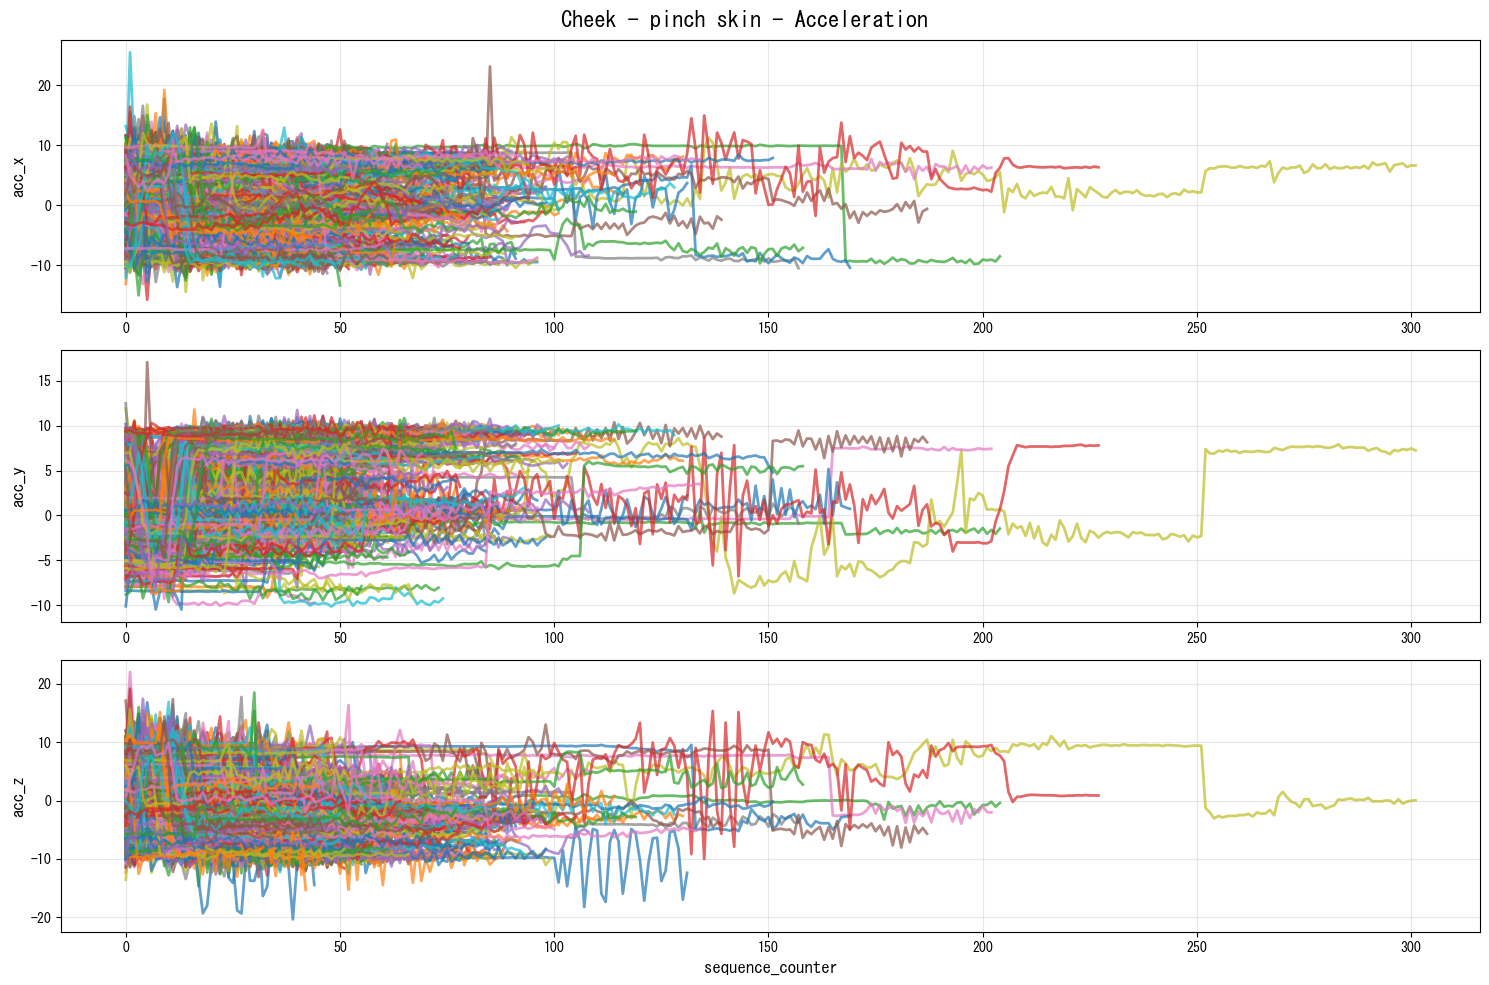


📊 Cheek - pinch skin の統計情報:
表示したシーケンス数: 637
利用可能な総シーケンス数: 637


In [ ]:
plot_acceleration_timeseries(train_reduced, "Cheek - pinch skin", num_sequences=None)

In [113]:
def plot_acceleration_timeseries_single(data, sequence_id, figsize=(15, 10)):
    """
    指定されたsequence_idの加速度センサーデータを時系列でプロット
    フェーズの変化を背景色で視覚化
    
    Parameters:
    -----------
    data : pandas.DataFrame
        データフレーム
    sequence_id : str
        プロットするsequence_id
    figsize : tuple
        図のサイズ
    """
    
    # 指定されたsequence_idのデータを抽出
    seq_data = data[data['sequence_id'] == sequence_id].copy()
    
    if len(seq_data) == 0:
        print(f"sequence_id '{sequence_id}' のデータが見つかりません")
        return
    
    # sequence_counterでソート
    seq_data = seq_data.sort_values('sequence_counter')
    
    # behaviorの値をテキスト表記に変換するマッピング
    behavior_to_text = {
        'Relaxes and moves hand to target location': 'Prepare',
        'Moves hand to target location': 'Moving',
        'Hand at target location': 'At Target',
        'Performs gesture': 'Gesture',
    }
    
    # フェーズの変化点を特定
    phase_changes = []
    unique_phases = []
    current_phase = None
    
    for i, (idx, row) in enumerate(seq_data.iterrows()):
        if row['behavior'] != current_phase:
            if current_phase is not None:
                phase_changes.append(i)
            current_phase = row['behavior']
            unique_phases.append(current_phase)
    
    # 最後のポイントを追加
    phase_changes.append(len(seq_data))
    
    # プロット作成
    fig, axes = plt.subplots(3, 1, figsize=figsize, sharex=True)
    
    # フェーズ別の色設定（テキスト表記に対応）
    phase_colors = {
        'Prepare': '#CCE5FF',        # 明るい青
        'Moving': '#FFD4A3',         # 明るいオレンジ
        'At Target': '#FFB3BA',      # 明るいピンク
        'Gesture': '#B3FFB3'         # 明るい緑
    }
    
    # 各軸に対してフェーズ背景を描画
    for ax in axes:
        start_idx = 0
        for i, phase in enumerate(unique_phases):
            end_idx = phase_changes[i]
            
            # 背景色を設定
            x_start = seq_data.iloc[start_idx]['sequence_counter']
            x_end = seq_data.iloc[end_idx-1]['sequence_counter'] if end_idx > 0 else x_start
            
            # behaviorの値をテキスト表記に変換
            phase_text = behavior_to_text.get(phase, phase)
            color = phase_colors.get(phase_text, '#F0F0F0')  # デフォルト色
            ax.axvspan(x_start, x_end, alpha=0.3, color=color, label=f'Phase: {phase_text}' if ax == axes[0] else "")
            
            start_idx = end_idx
    
    # acc_x
    axes[0].plot(seq_data['sequence_counter'], seq_data['acc_x'], 
                 color='red', linewidth=2, marker='o', markersize=4, zorder=5)
    axes[0].set_ylabel('acc_x', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Sequence ID: {sequence_id}', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # acc_y
    axes[1].plot(seq_data['sequence_counter'], seq_data['acc_y'], 
                 color='green', linewidth=2, marker='o', markersize=4, zorder=5)
    axes[1].set_ylabel('acc_y', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # acc_z
    axes[2].plot(seq_data['sequence_counter'], seq_data['acc_z'], 
                 color='blue', linewidth=2, marker='o', markersize=4, zorder=5)
    axes[2].set_ylabel('acc_z', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Sequence Counter', fontsize=12, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    # フェーズ名を最下段のグラフ（acc_z）の下部に表示
    start_idx = 0
    for i, phase in enumerate(unique_phases):
        end_idx = phase_changes[i]
        
        # フェーズ名を表示する位置を計算
        x_start = seq_data.iloc[start_idx]['sequence_counter']
        x_end = seq_data.iloc[end_idx-1]['sequence_counter'] if end_idx > 0 else x_start
        x_mid = (x_start + x_end) / 2
        
        # 最下段のグラフの下部に配置
        y_min = axes[2].get_ylim()[0]
        y_range = axes[2].get_ylim()[1] - axes[2].get_ylim()[0]
        y_pos = y_min - y_range * 0.15  # グラフの下部から少し離れた位置
        
        # behaviorの値をテキスト表記に変換
        phase_text = behavior_to_text.get(phase, phase)
        
        # フェーズに応じてテキストの色を調整
        text_color_map = {
            'Prepare': 'darkblue',
            'Moving': 'darkorange', 
            'At Target': 'darkred',
            'Gesture': 'darkgreen'
        }
        text_color = text_color_map.get(phase_text, 'black')
        axes[2].text(x_mid, y_pos, phase_text, 
                    ha='center', va='center', fontweight='bold', color=text_color,
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        start_idx = end_idx
    
    # 凡例を追加（最上段のグラフのみ）
    if len(unique_phases) > 1:
        # カスタム凡例を作成
        legend_elements = []
        for phase in unique_phases:
            phase_text = behavior_to_text.get(phase, phase)
            color = phase_colors.get(phase_text, '#F0F0F0')
            legend_elements.append(plt.Rectangle((0,0),1,1, facecolor=color, alpha=0.3, 
                                               edgecolor='black', label=f'{phase_text} phase'))
        axes[0].legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    
    # 統計情報を表示
    unique_phases_text = [behavior_to_text.get(phase, phase) for phase in unique_phases]
    phase_info = f"フェーズ変化: {' → '.join(unique_phases_text)}"
    info_text = f"""
    シーケンスID: {seq_data['sequence_id'].iloc[0]}
    被験者ID: {seq_data['subject'].iloc[0]}
    データポイント数: {len(seq_data)}
    ジェスチャー: {seq_data['gesture'].iloc[0]}
    BFRBタイプ: {seq_data['sequence_type'].iloc[0]}
    方向: {seq_data['orientation'].iloc[0]}
    {phase_info}
    """
    
    # 統計情報を図の右上に配置
    fig.text(0.98, 0.98, info_text, transform=fig.transFigure, 
             fontsize=10, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # 統計情報をコンソールにも表示
    print(f"\n📊 {sequence_id} の統計情報:")
    print(f"  データポイント数: {len(seq_data)}")
    print(f"  フェーズ変化: {' → '.join(unique_phases_text)}")
    print(f"  acc_x - 平均: {seq_data['acc_x'].mean():.4f}, 標準偏差: {seq_data['acc_x'].std():.4f}")
    print(f"  acc_y - 平均: {seq_data['acc_y'].mean():.4f}, 標準偏差: {seq_data['acc_y'].std():.4f}")
    print(f"  acc_z - 平均: {seq_data['acc_z'].mean():.4f}, 標準偏差: {seq_data['acc_z'].std():.4f}")
    
    # フェーズ別の統計情報も表示
    print(f"\n📈 フェーズ別統計:")
    for phase in unique_phases:
        phase_text = behavior_to_text.get(phase, phase)
        phase_data = seq_data[seq_data['behavior'] == phase]
        print(f"  {phase_text}: {len(phase_data)} データポイント ({len(phase_data)/len(seq_data)*100:.1f}%)")

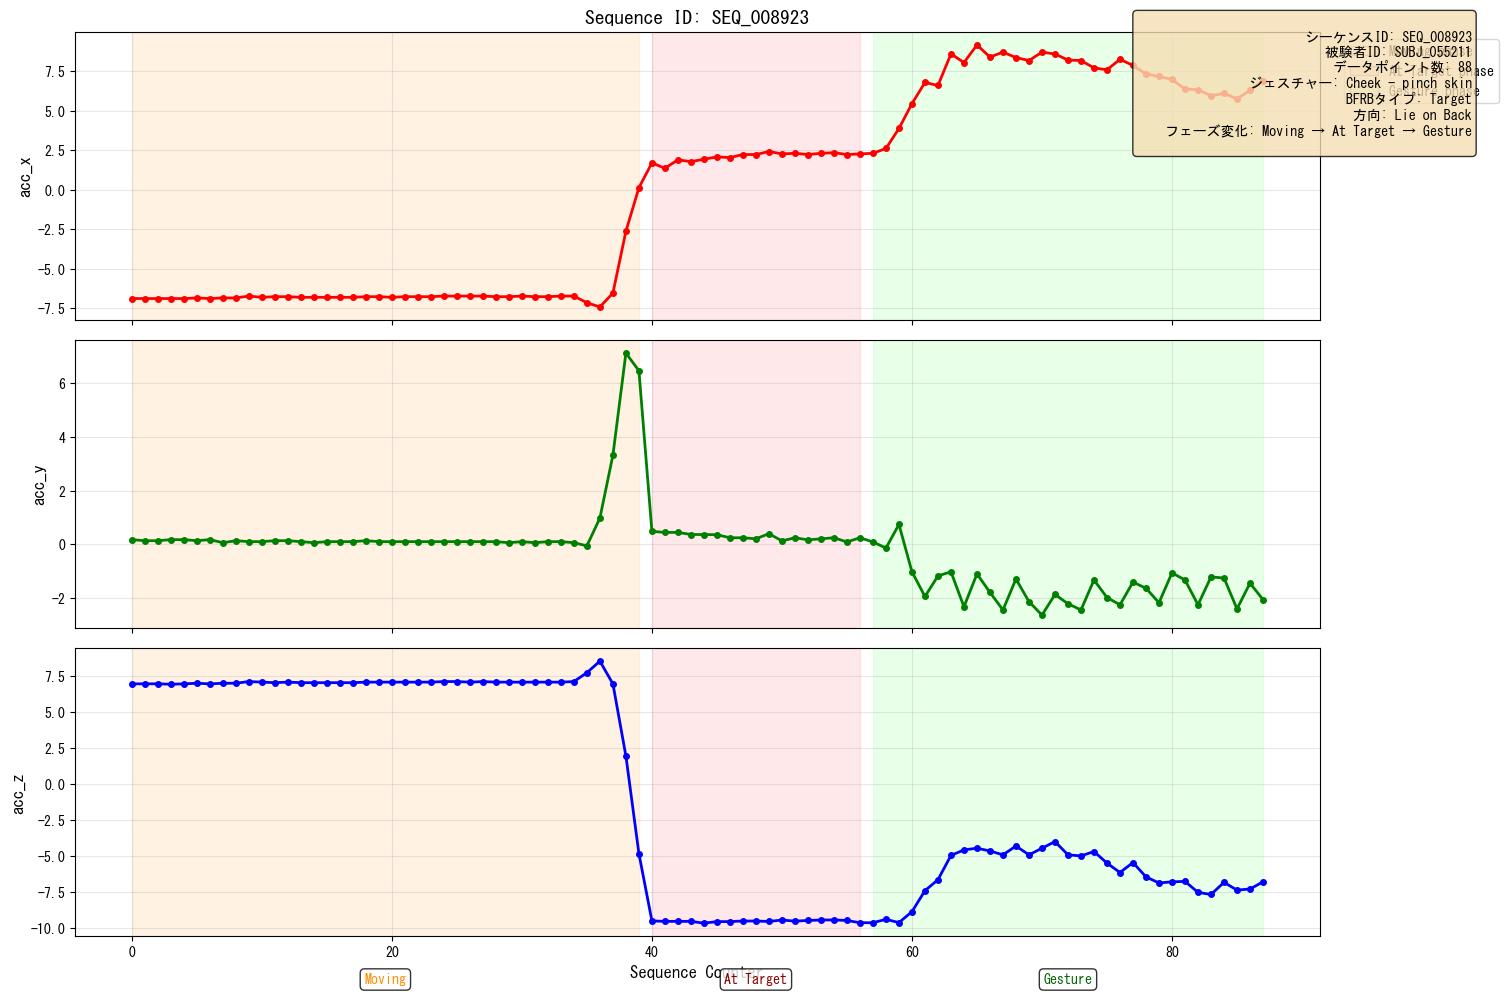


📊 SEQ_008923 の統計情報:
  データポイント数: 88
  フェーズ変化: Moving → At Target → Gesture
  acc_x - 平均: -0.0964, 標準偏差: 6.3008
  acc_y - 平均: -0.2473, 標準偏差: 1.4971
  acc_z - 平均: -0.9941, 標準偏差: 7.3555

📈 フェーズ別統計:
  Moving: 40 データポイント (45.5%)
  At Target: 17 データポイント (19.3%)
  Gesture: 31 データポイント (35.2%)


In [114]:
# sequence_idにごとに時系列データを確認
gesture_sequences = train_reduced.groupby('gesture')['sequence_id'].unique()

# 特定のジェスチャーの時系列データをプロット
target_gesture = "Cheek - pinch skin"
target_sequences = gesture_sequences.get(target_gesture, [])
if len(target_sequences) > 0:
    plot_acceleration_timeseries_single(train_reduced, target_sequences[80])

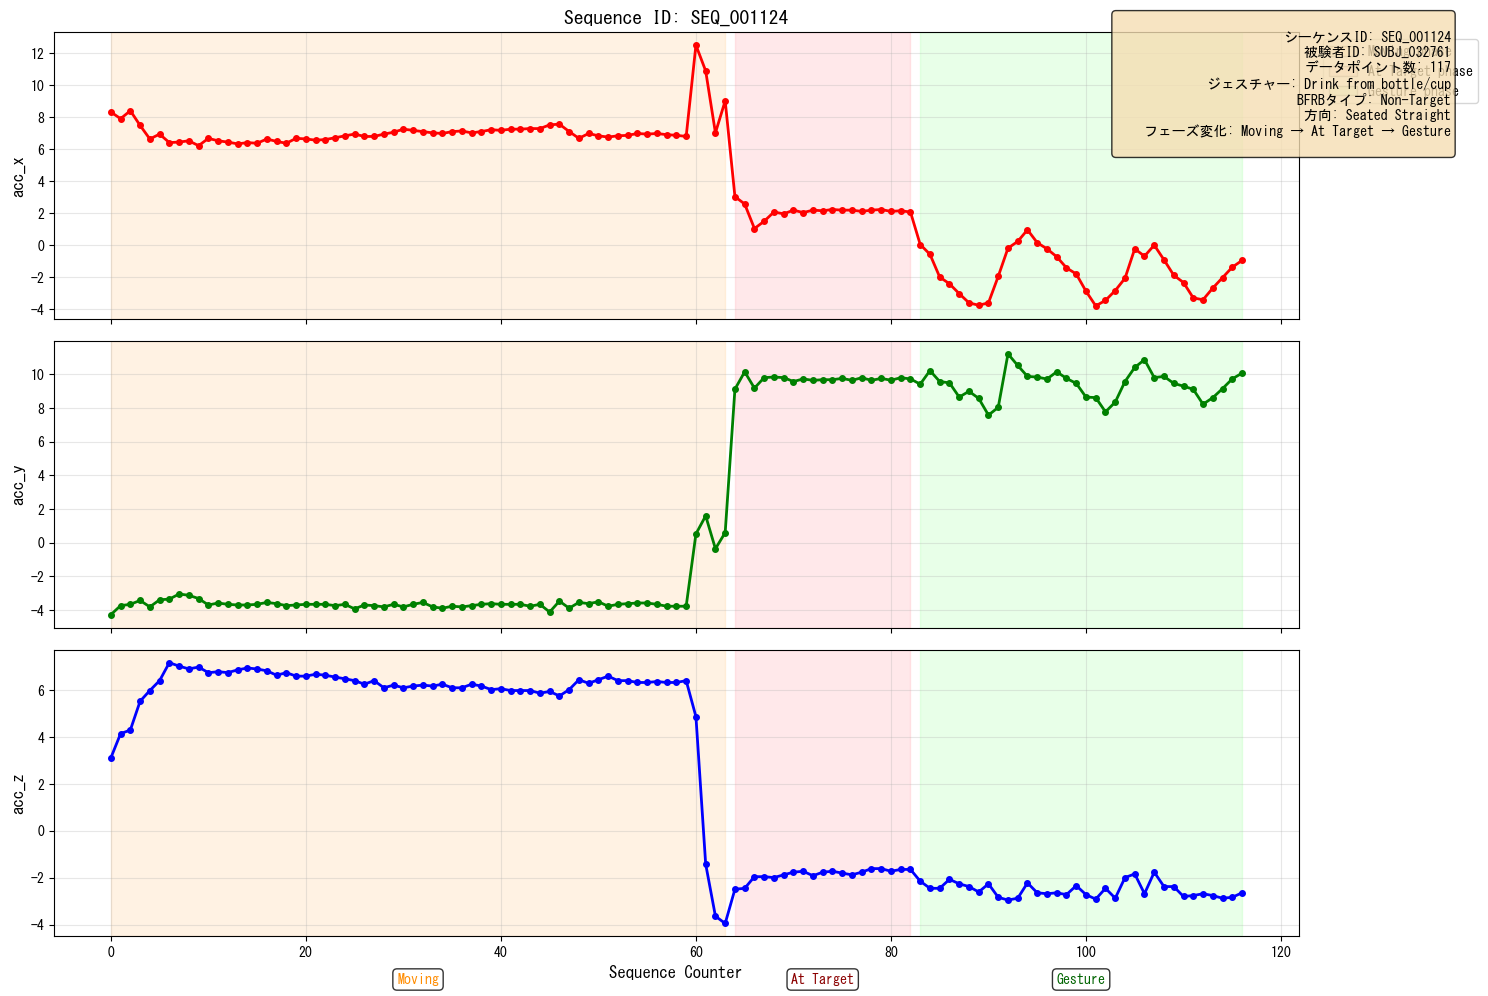


📊 SEQ_001124 の統計情報:
  データポイント数: 117
  フェーズ変化: Moving → At Target → Gesture
  acc_x - 平均: 3.7344, 標準偏差: 4.0625
  acc_y - 平均: 2.4336, 標準偏差: 6.5000
  acc_z - 平均: 2.1328, 標準偏差: 4.3320

📈 フェーズ別統計:
  Moving: 64 データポイント (54.7%)
  At Target: 19 データポイント (16.2%)
  Gesture: 34 データポイント (29.1%)


In [115]:
# sequence_idにごとに時系列データを確認
gesture_sequences = train_reduced.groupby('gesture')['sequence_id'].unique()

# 特定のジェスチャーの時系列データをプロット
target_gesture = "Drink from bottle/cup"
target_sequences = gesture_sequences.get(target_gesture, [])
if len(target_sequences) > 0:
    plot_acceleration_timeseries_single(train_reduced, target_sequences[3])